# Probabilistic forecasting: prediction intervals and prediction distribution

When trying to anticipate future values, most forecasting models try to predict what will be the most likely value. This is called point-forecasting. Although knowing in advance the expected value of a time series is useful in almost every business case, this kind of prediction does not provide any information about the confidence of the model nor the prediction uncertainty.

Probabilistic forecasting, as opposed to point-forecasting, is a family of techniques that allow for predicting the expected distribution of the outcome instead of a single future value. This type of forecasting provides much rich information since it allows for creating prediction intervals, the range of likely values where the true value may fall. More formally, a prediction interval defines the interval within which the true value of the response variable is expected to be found with a given probability.

Skforecast implements several methods for probabilistic forecasting, including:

**Bootstrapped residuals**

Bootstrapping is a statistical technique that allows for estimating the distribution of a statistic by resampling the data with replacement. In the context of forecasting, bootstrapping the residuals of a model allows for estimating the distribution of the errors, which can be used to create prediction intervals. Four methods are available in Skforecast for bootstrapping the residuals:

+ `predict_bootstrapping`: this method generates multiple forecasting predictions through a bootstrapping process. By sampling from a collection of past observed errors (the residuals), each bootstrapping iteration generates a different set of predictions. The output is a `pandas DataFrame` with one row for each predicted step and one column for each bootstrapping iteration.

+ `predict_interval(method='bootstrapping')`: this method estimates quantile prediction intervals using the values generated with `predict_bootstrapping`.

+ `predict_quantiles`: this method estimates a list of quantile predictions using the values generated with `predict_bootstrapping`.

+ `predict_dist`: this method fits a parametric distribution using the values generated with `predict_bootstrapping`. Any of the continuous distributions available in [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions) can be used.

The four methods can use in-sample residuals (default) or out-sample residuals. In both cases, the residuals can be conditioned on the predicted value to try to account for the existence of a correlation between the predicted values and the residuals.

**Quantile regression**

Quantile regression is a technique for estimating the conditional quantiles of a response variable. By combining the predictions of two quantile regressors, an interval can be constructed, where each model estimates one of the interval’s boundaries. For example, models trained for \( Q = 0.1 \) and \( Q = 0.9 \) produce an 80% prediction interval (\( 90\% - 10\% = 80\% \)).

If a machine learning algorithm capable of modeling quantiles is used as the `regressor` in a [ForecasterDirect](../api/forecasterdirect.html) or [ForecasterDirectMultiVariate](../api/forecasterdirectmultivariate.html), the `predict` method will return predictions for a specified quantile. By creating two forecasters, each configured with a different quantile, their predictions can be combined to generate a prediction interval.

**Conformal prediction**

Conformal prediction is a framework for constructing prediction intervals that are valid with respect to the coverage probability. The interval is created by combining the predictions of a point-forecasting model with its residuals. These residuals help estimate the width of the prediction interval, which is then added to the point forecast. Skforecast implements Split Conformal Prediction (SCP) through the `predict_interval(method='conformal')` method.

Conformal methods can also calibrate prediction intervals generated by other techniques, such as quantile regression or bootstrapped residuals. In this case, the conformal method adjusts the prediction intervals to ensure they remain valid with respect to the coverage probability. Skforecast provides this functionality through the `ConformalInterval` transformer.

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

<p>
There are several well-established <a href="https://mapie.readthedocs.io/en/stable/theoretical_description_regression.html" target="_blank">methods for conformal prediction</a>, each with its own characteristics and assumptions. However, when applied to time series forecasting, their coverage guarantees are only valid for one-step-ahead predictions. For multi-step-ahead predictions, the coverage probability is not guaranteed. Skforecast implements Split Conformal Prediction (SCP) due to its simplicity and efficiency. 

</div>


<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

<h3>Which Method to Use?</h3>

<p>There is no definitive answer to this question, as the resulting coverage may vary depending on the dataset and regressor. However, some general guidelines can be followed:</p>

<ul>
    <li>
        <strong>Bootstrapped residuals</strong>: This method achieves good results in most cases, especially when using residuals conditioned on the predicted value (<code>use_binned_residuals = True</code>). However, it is computationally expensive, particularly when using a large number of bootstrapping iterations, and may not scale well to large datasets or multiple time series.<br><br>
    </li>
    <li>
        <strong>Quantile regression</strong>: A suitable choice when the regressor is capable of modeling quantiles. However, two forecasters must be trained—one for each quantile—which can be computationally expensive.<br><br>
    </li>
    <li>
        <strong>Conformal Prediction</strong>: Similar results to bootstrapping, but more computationally efficient (fast).<br><br>
    </li>
</ul>

<p>None of these methods guarantee coverage probability for multi-step predictions. Therefore, it is strongly recommended to validate the empirical coverage obtained with the chosen method. If the coverage is not satisfactory, the prediction intervals can be calibrated using the <code>ConformalInterval</code> transformer.</p>

<p>For bootstrapped and conformal methods, it is recommended to use out-sample residuals (known as calibration residuals in conformal literature) as they provide a more realistic estimate of the prediction uncertainty. If in-sample residuals are used, the prediction intervals may be too narrow, resulting in low coverage.</p>


</div>

## Prediction intervals using bootstrapped residuals

The error of a one-step-ahead forecast is defined as the difference between the actual value and the predicted value ($e_t = y_t - \hat{y}_{t|t-1}$). By assuming that future errors will be similar to past errors, it is possible to simulate different predictions by taking samples from the collection of errors previously seen in the past (i.e., the residuals) and adding them to the predictions.

<p style="text-align: center">
<img src="../img/diagram-bootstrapping-prediction-intervals.png" style="width: 500px;">
<br>
<font size="2.5"> <i>Diagram bootstrapping prediction process.</i></font>
</p>

Repeatedly performing this process creates a collection of slightly different predictions, which represent the distribution of possible outcomes due to the expected variance in the forecasting process.

<p style="text-align: center">
<img src="../img/diagram-bootstrapping-prediction-intervals-2.png" style="width: 500px;">
<br>
<font size="2.5"> <i>Bootstrapping predictions.</i></font>
</p>

Using the outcome of the bootstrapping process, prediction intervals can be computed by calculating the $α/2$ and $1 − α/2$ percentiles at each forecasting horizon. 

<p style="text-align: center">
<img src="../img/forecasting-intervals.gif" style="width: 800px;">
</p>

Alternatively, it is also possible to fit a parametric distribution for each forecast horizon. 

One of the main advantages of this strategy is that it requires only a single model to estimate any interval. However, performing hundreds or thousands of bootstrapping iterations can be computationally expensive and may not always be feasible.

### Libraries and data

In [3]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from skforecast.plot import plot_residuals
from skforecast.plot import plot_prediction_distribution
from skforecast.plot import plot_prediction_intervals
from pprint import pprint

# Modelling and Forecasting
# ==============================================================================
from scipy.stats import norm
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_pinball_loss
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster
from skforecast.metrics import calculate_coverage

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')
plt.style.use('seaborn-v0_8-darkgrid')

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

To create a sufficiently illustrative user guide, the data download process takes about 1 minute, and some functions called during the guide may take a few seconds to run. We appreciate your patience.

</div>

In [4]:
# Data download
# ==============================================================================
data = fetch_dataset(name='bike_sharing_extended_features')
data.head(2)

bike_sharing_extended_features
------------------------------
Hourly usage of the bike share system in the city of Washington D.C. during the
years 2011 and 2012. In addition to the number of users per hour, the dataset
was enriched by introducing supplementary features. Addition includes calendar-
based variables (day of the week, hour of the day, month, etc.), indicators for
sunlight, incorporation of rolling temperature averages, and the creation of
polynomial features generated from variable pairs. All cyclic variables are
encoded using sine and cosine functions to ensure accurate representation.
Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.
https://doi.org/10.24432/C5W894.
Shape of the dataset: (17352, 90)


,users,weather,month_sin,month_cos,week_of_year_sin,week_of_year_cos,week_day_sin,week_day_cos,hour_day_sin,hour_day_cos,...,temp_roll_mean_1_day,temp_roll_mean_7_day,temp_roll_max_1_day,temp_roll_min_1_day,temp_roll_max_7_day,temp_roll_min_7_day,holiday_previous_day,holiday_next_day,temp,holiday
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-08 00:00:00,25.0,mist,0.5,0.866025,0.120537,0.992709,-0.781832,0.62349,0.258819,0.965926,...,8.063334,10.127976,9.02,6.56,18.86,4.92,0.0,0.0,7.38,0.0
2011-01-08 01:00:00,16.0,mist,0.5,0.866025,0.120537,0.992709,-0.781832,0.62349,0.500000,0.866025,...,8.029166,10.113334,9.02,6.56,18.86,4.92,0.0,0.0,7.38,0.0


In [5]:
# One hot encoding of categorical variables
# ==============================================================================
encoder = ColumnTransformer(
              [('one_hot_encoder', OneHotEncoder(sparse_output=False), ['weather'])],
              remainder='passthrough',
              verbose_feature_names_out=False
          ).set_output(transform="pandas")
data = encoder.fit_transform(data)

In [6]:
# Select exogenous variables to be included in the model
# ==============================================================================
exog_features = [
    'weather_clear', 'weather_mist', 'weather_rain', 'month_sin', 'month_cos',
    'week_of_year_sin', 'week_of_year_cos', 'week_day_sin', 'week_day_cos',
    'hour_day_sin', 'hour_day_cos', 'sunrise_hour_sin', 'sunrise_hour_cos',
    'sunset_hour_sin', 'sunset_hour_cos', 'temp', 'holiday'
]
data = data[['users'] + exog_features]

In [7]:
# Split train-validation-test
# ==============================================================================
data = data.loc['2011-05-30 23:59:00':, :]
end_train = '2012-08-30 23:59:00'
end_validation = '2012-11-15 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2011-05-31 00:00:00 --- 2012-08-30 23:00:00  (n=10992)
Dates validacion : 2012-08-31 00:00:00 --- 2012-11-15 23:00:00  (n=1848)
Dates test       : 2012-11-16 00:00:00 --- 2012-12-30 23:00:00  (n=1080)


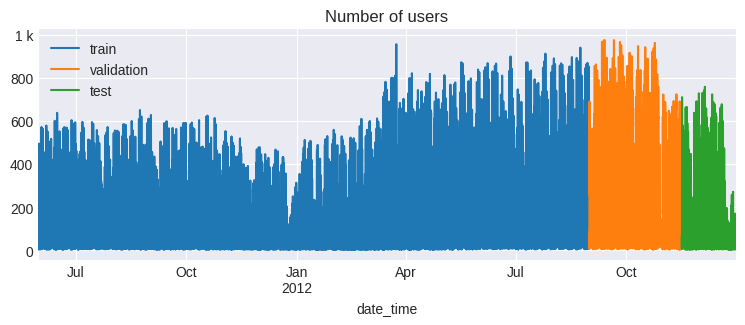

In [8]:
# Plot time series partition
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 3))
data_train['users'].plot(label='train', ax=ax)
data_val['users'].plot(label='validation', ax=ax)
data_test['users'].plot(label='test', ax=ax)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_title('Number of users')
ax.legend();

### Intervals with In-sample residuals

By default, intervals can be computed using in-sample residuals (residuals from the training set), either by calling the `predict_interval()` method, or by performing a full [backtesting](../user_guides/backtesting.html) procedure. However, this can result in intervals that are too narrow (overly optimistic).

In [9]:
# Create and fit forecaster
# ==============================================================================
params = {
    "n_estimators": 600,
    "max_depth": 6,
    "min_data_in_leaf": 88,
    "learning_rate": 0.2520098236227423,
    "feature_fraction": 0.6,
    "max_bin": 75,
    "reg_alpha": 1.0,
    "reg_lambda": 0.8,
}
lags = 48

forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=15926, verbose=-1, **params),
                 lags      = lags
             )
forecaster.fit(
    y    = data.loc[:end_validation, 'users'],
    exog = data.loc[:end_validation, exog_features]
)

In [10]:
# In-sample residuals stored during fit
# ==============================================================================
print("Amount of residuals stored:", len(forecaster.in_sample_residuals_))
forecaster.in_sample_residuals_

Amount of residuals stored: 10000


array([  3.73729229,   6.14244593, -23.25763071, ...,  -8.13924189,
       -16.96211761,  -5.39081562])

In [11]:
# Predict interval with in-sample residuals
# ==============================================================================
predictions = forecaster.predict_interval(
                  exog     = data_test[exog_features],
                  steps    = 7,
                  interval = [10, 90],
                  method   = 'bootstrapping',
              )
predictions

,pred,lower_bound,upper_bound
2012-11-16 00:00:00,70.009970,55.577593,83.459464
2012-11-16 01:00:00,45.679914,30.671130,64.295624
2012-11-16 02:00:00,19.225220,0.425122,35.326497
2012-11-16 03:00:00,-0.039409,-12.275856,18.443080
2012-11-16 04:00:00,0.154831,-14.703684,14.404548
2012-11-16 05:00:00,37.330998,22.981872,54.089669
2012-11-16 06:00:00,116.737843,59.197419,145.115168


The `backtesting_forecaster()` function is used to generate the prediction intervals for the entire test set and calculate coverage of a given interval.

+ `use_in_sample_residuals = True` is used to compute the intervals using in-sample residuals.

+ The `interval` argument indicates the desired coverage probability of the prediction intervals. In this case, `interval` is set to `[10, 90]`, which means that the prediction intervals are calculated for the 10th and 90th percentiles, resulting in a theoretical coverage probability of 80%. 

+ The `n_boot` argument is used to specify the number of bootstrap samples to be used in estimating the prediction intervals. The larger the number of samples, the more accurate the prediction intervals will be, but the longer the calculation will take.

In [12]:
# Backtesting with prediction intervals in test data using in-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24, 
         initial_train_size = len(data.loc[:end_validation]),
         refit              = False
     )

metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['users'],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = [10, 90],  # 80% prediction interval
                          interval_method         = 'bootstrapping',
                          n_boot                  = 250,
                          use_in_sample_residuals = True,  # Use in-sample residuals
                          use_binned_residuals    = False,
                          n_jobs                  = 'auto',
                          verbose                 = False,
                          show_progress           = True
                      )

predictions.head(5)

  0%|          | 0/45 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2012-11-16 00:00:00,70.009970,55.577593,83.459464
2012-11-16 01:00:00,45.679914,30.671130,64.295624
2012-11-16 02:00:00,19.225220,0.425122,35.326497
2012-11-16 03:00:00,-0.039409,-12.275856,18.443080
2012-11-16 04:00:00,0.154831,-14.703684,14.404548


Predicted interval coverage: 62.5 %
Area of the interval: 91410.85


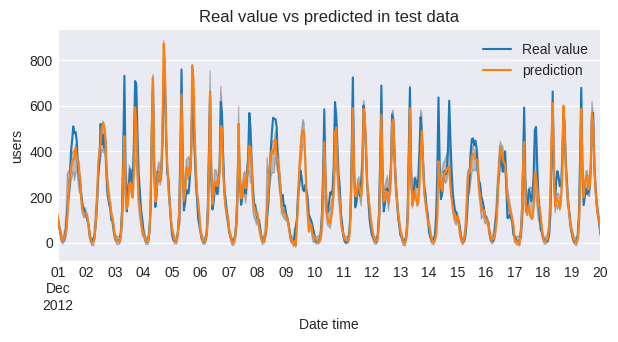

In [13]:
# Plot intervals
# ==============================================================================
plot_prediction_intervals(
    predictions     = predictions,
    y_true          = data_test,
    target_variable = "users",
    initial_x_zoom  = ['2012-12-01', '2012-12-20'],
    title           = "Real value vs predicted in test data",
    xaxis_title     = "Date time",
    yaxis_title     = "users",
)

# Predicted interval coverage (on test data)
# ==============================================================================
coverage = calculate_coverage(
    y_true = data.loc[end_validation:, 'users'],
    lower_bound = predictions["lower_bound"], 
    upper_bound = predictions["upper_bound"]
)
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions["upper_bound"] - predictions["lower_bound"]).sum()
print(f"Area of the interval: {round(area, 2)}")

The prediction intervals exhibit overconfidence as they tend to be excessively narrow, resulting in a true coverage that falls below the nominal coverage (80 %). This phenomenon arises from the tendency of in-sample residuals to often overestimate the predictive capacity of the model.

### Out-sample residuals (non-conditioned on predicted values)

To address the issue of overoptimistic intervals, it is possible to use out-sample residuals (residuals from a validation set not seen during training) to estimate the prediction intervals. These residuals can be obtained through backtesting.

In [14]:
# Backtesting on validation data to obtain out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24, 
         initial_train_size = len(data.loc[:end_train]),
         refit              = False
     )

_, predictions_val = backtesting_forecaster(
                         forecaster    = forecaster,
                         y             = data.loc[:end_validation, 'users'],
                         exog          = data.loc[:end_validation, exog_features],
                         cv            = cv,
                         metric        = 'mean_absolute_error',
                         n_jobs        = 'auto',
                         verbose       = False,
                         show_progress = True
                     )

  0%|          | 0/77 [00:00<?, ?it/s]

positive    1118
negative     730
Name: count, dtype: int64


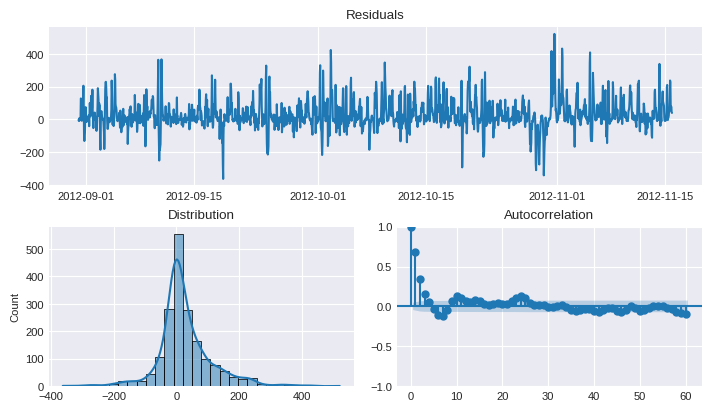

In [15]:
# Out-sample residuals distribution
# ==============================================================================
residuals = data.loc[predictions_val.index, 'users'] - predictions_val['pred']
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
plt.rcParams.update({'font.size': 8})
_ = plot_residuals(residuals=residuals, figsize=(7, 4))

Then, `set_out_sample_residuals()` method is used to specify the computed out-sample residuals.

In [16]:
# Store out-sample residuals in the forecaster
# ==============================================================================
forecaster.set_out_sample_residuals(
    y_true = data.loc[predictions_val.index, 'users'], 
    y_pred = predictions_val['pred']
)

Now that the new residuals have been added to the forecaster, the prediction intervals can be calculated using `use_in_sample_residuals = False`.

In [17]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24, 
         initial_train_size = len(data.loc[:end_validation]),
         refit              = False
     )

metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['users'],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = [10, 90],  # 80% prediction interval
                          interval_method         = 'bootstrapping',
                          n_boot                  = 250,
                          use_in_sample_residuals = False,  # Use out-sample residuals
                          use_binned_residuals    = False,
                          n_jobs                  = 'auto',
                          verbose                 = False,
                          show_progress           = True
                      )

predictions.head(5)

  0%|          | 0/45 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2012-11-16 00:00:00,70.009970,25.270608,221.130357
2012-11-16 01:00:00,45.679914,5.086782,174.075303
2012-11-16 02:00:00,19.225220,-4.724422,207.296663
2012-11-16 03:00:00,-0.039409,-9.847624,223.921740
2012-11-16 04:00:00,0.154831,-26.401489,315.698238


Predicted interval coverage: 73.98 %
Area of the interval: 318517.93


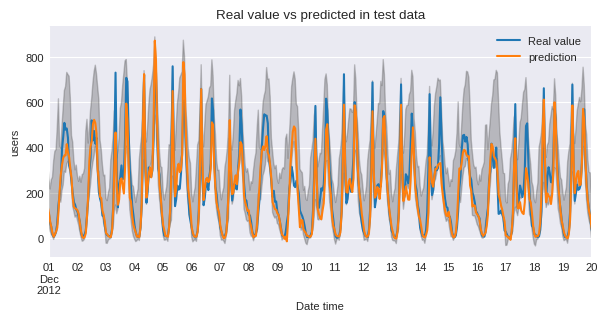

In [18]:
# Plot intervals
# ==============================================================================
plot_prediction_intervals(
    predictions     = predictions,
    y_true          = data_test,
    target_variable = "users",
    initial_x_zoom  = ['2012-12-01', '2012-12-20'],
    title           = "Real value vs predicted in test data",
    xaxis_title     = "Date time",
    yaxis_title     = "users",
)

# Predicted interval coverage (on test data)
# ==============================================================================
coverage = calculate_coverage(
    y_true      = data.loc[end_validation:, 'users'],
    lower_bound = predictions["lower_bound"], 
    upper_bound = predictions["upper_bound"]
)
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions["upper_bound"] - predictions["lower_bound"]).sum()
print(f"Area of the interval: {round(area, 2)}")

The resulting prediction intervals derived from the out-sample residuals are wider than those generated using the in-sample residuals. This results in an empirical coverage that is closer to the nominal coverage (80 %), although still lower. Examining the plot, it is easy to see that the intervals are particularly wide when the predicted values are low, indicating that the model is not able to properly locate the uncertainty of its predictions.

### Intervals conditioned on predicted values (binned residuals)

The bootstrapping process assumes that the residuals are independently distributed so that they can be used independently of the predicted value. In reality, this is rarely true; in most cases, the magnitude of the residuals is correlated with the magnitude of the predicted value. In this case, for example, one would hardly expect the error to be the same when the predicted number of users is close to zero as when it is in the hundreds.

To account for the dependence between the residuals and the predicted values, skforecast allows to **partition the residuals into *K* bins**, where each bin is associated with a range of predicted values. Using this strategy, the bootstrapping process samples the residuals from different bins depending on the predicted value, which can improve the coverage of the interval while adjusting the width if necessary, allowing the model to **better distribute the uncertainty of its predictions**.

Internally, skforecast uses a [`QuantileBinner`](../api/preprocessing.html#skforecast.preprocessing.preprocessing.QuantileBinner) class to bin data into quantile-based bins using `numpy.percentile`. This class is similar to [KBinsDiscretizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html) but faster for binning data into quantile-based bins. Bin intervals are defined following the convention: bins[i-1] <= x < bins[i]. The binning process can be adjusted using the argument `binner_kwargs` of the Forecaster object.

In [19]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor     = LGBMRegressor(random_state=15926, verbose=-1, **params),
                 lags          = lags,
                 binner_kwargs = {'n_bins': 10}   
             )
forecaster.fit(
    y    = data.loc[:end_validation, 'users'],
    exog = data.loc[:end_validation, exog_features]
)

During the training process, the forecaster uses the in-sample predictions to define the intervals at which the residuals are stored depending on the predicted value to which they are related (`binner_intervals_` attribute). 

Although not used in this example, the in-sample residuals are divided into bins and stored in the `in_sample_residuals_by_bin_` attribute.

In [20]:
# Intervals of the residual bins
# ==============================================================================
pprint(forecaster.binner_intervals_)

{0: (-8.229467171553717, 11.116037535200665),
 1: (11.116037535200665, 31.879155847370434),
 2: (31.879155847370434, 75.9019071402224),
 3: (75.9019071402224, 124.5691653220086),
 4: (124.5691653220086, 170.35484312260417),
 5: (170.35484312260417, 218.96823239624555),
 6: (218.96823239624555, 278.6496576655771),
 7: (278.6496576655771, 355.13229168292287),
 8: (355.13229168292287, 486.1660497574729),
 9: (486.1660497574729, 970.517259284916)}


In [21]:
# Number of in-sample residuals by bin
# ==============================================================================
for k, v in forecaster.in_sample_residuals_by_bin_.items():
    print(f"Bin {k}: n={len(v)}")

Bin 0: n=1000
Bin 1: n=1000
Bin 2: n=1000
Bin 3: n=1000
Bin 4: n=1000
Bin 5: n=1000
Bin 6: n=1000
Bin 7: n=1000
Bin 8: n=1000
Bin 9: n=1000


The `set_out_sample_residuals()` method will bin the residuals according to the intervals learned during fitting. To avoid using too much memory, the number of residuals stored per bin is limited to `10_000 // self.binner.n_bins_`. The predictions obtained in the backtesting are used.

In [22]:
# Store out-sample residuals in the forecaster
# ==============================================================================
forecaster.set_out_sample_residuals(
    y_true = data.loc[predictions_val.index, 'users'], 
    y_pred = predictions_val['pred']
)

In [23]:
# Number of out-sample residuals by bin
# ==============================================================================
for k, v in forecaster.out_sample_residuals_by_bin_.items():
    print(f"Bin {k}: n={len(v)}")

Bin 0: n=114
Bin 1: n=190
Bin 2: n=183
Bin 3: n=162
Bin 4: n=126
Bin 5: n=164
Bin 6: n=175
Bin 7: n=236
Bin 8: n=232
Bin 9: n=266


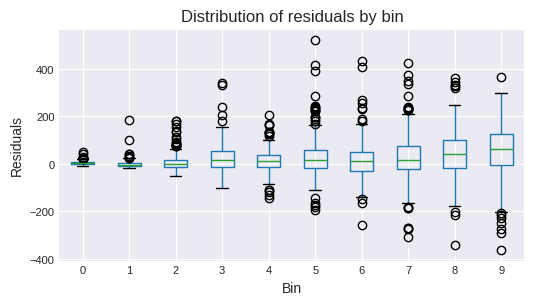

In [24]:
# Distribution of the residual by bin
# ==============================================================================
out_sample_residuals_by_bin_df = pd.DataFrame(
    dict(
        [(k, pd.Series(v))
         for k, v in forecaster.out_sample_residuals_by_bin_.items()]
    )
)

fig, ax = plt.subplots(figsize=(6, 3))
out_sample_residuals_by_bin_df.boxplot(ax=ax)
ax.set_title("Distribution of residuals by bin", fontsize=12)
ax.set_xlabel("Bin", fontsize=10)
ax.set_ylabel("Residuals", fontsize=10)
plt.show();

The box plots show how the spread and magnitude of the residuals differ depending on the predicted value. For example, for bin 0, whose predicted value is in the interval (-8.2, 11.1), the residuals never exceed an absolute value of 100, while for bin 9, for predicted values in the interval (486.2, 970.5), they often do.

Finally, the prediction intervals for the test data are estimated using the backtesting process, with out-sample residuals conditioned on the predicted values.

In [25]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24, 
         initial_train_size = len(data.loc[:end_validation]),
         refit              = False
     )
metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['users'],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = [10, 90],  # 80% prediction interval
                          interval_method         = 'bootstrapping',
                          n_boot                  = 250,
                          use_in_sample_residuals = False,  # Use out-sample residuals
                          use_binned_residuals    = True,  # Use binned residuals
                          n_jobs                  = 'auto',
                          verbose                 = False,
                          show_progress           = True
                     )
predictions.head(3)

  0%|          | 0/45 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2012-11-16 00:00:00,70.009970,48.514148,144.262872
2012-11-16 01:00:00,45.679914,19.591406,125.205621
2012-11-16 02:00:00,19.225220,6.411865,76.327318


Predicted interval coverage: 84.54 %
Area of the interval: 283629.44


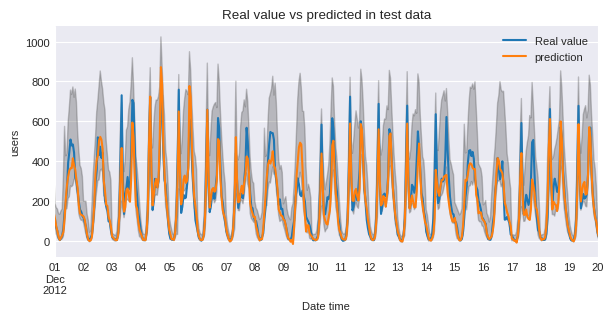

In [26]:
# Plot intervals
# ==============================================================================
plot_prediction_intervals(
    predictions     = predictions,
    y_true          = data_test,
    target_variable = "users",
    initial_x_zoom  = ['2012-12-01', '2012-12-20'],
    title           = "Real value vs predicted in test data",
    xaxis_title     = "Date time",
    yaxis_title     = "users",
)

# Predicted interval coverage (on test data)
# ==============================================================================
coverage = calculate_coverage(
    y_true      = data.loc[end_validation:, 'users'],
    lower_bound = predictions["lower_bound"], 
    upper_bound = predictions["upper_bound"]
)
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions["upper_bound"] - predictions["lower_bound"]).sum()
print(f"Area of the interval: {round(area, 2)}")

When using out-sample residuals conditioned on the predicted value, the area of the interval is significantly reduced and the uncertainty is mainly allocated to the predictions with high values. The empirical coverage is slightly above the expected coverage, which means that the estimated intervals are conservative.

### Predict bootstraping, interval, quantile and distribution

The previous sections have demonstrated the use of the backtesting process to estimate the prediction interval over a given period of time. The goal is to mimic the behavior of the model in production by running predictions at regular intervals, incrementally updating the input data.

Alternatively, it is possible to run a single prediction that forecasts *N* steps ahead without going through the entire backtesting process. In such cases, skforecast provides four different methods: `predict_bootstrapping`, `predict_interval`, `predict_quantile` and `predict_distribution`.

If the user needs to run a backtesting process using one of these prediction methods, the `interval` argument of `backtesting_forecaster()` can be specified as:

- If `list` or `tuple`: Sequence of percentiles to compute, each value must be between 0 and 100 inclusive. For example, a 95% confidence interval can be specified as `interval = [2.5, 97.5]` or multiple percentiles (e.g. 10, 50 and 90) as `interval = [10, 50, 90]`.

- If `'bootstrapping'` (str): `n_boot` bootstrapping predictions will be generated.

- If `scipy.stats distribution object`, the distribution parameters will be estimated for each prediction.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

All of these methods can be used either with in-sample or out-sample residuals using the <code>use_in_sample_residuals</code> argument, and with binned intervals conditioned on predicted values using the <code>use_binned_residuals</code> argument.

</div>

**Predict Bootstraping** 

The `predict_bootstrapping` method performs the `n_boot` bootstrapping iterations that generate the alternative prediction paths. These are the underlying values used to compute the intervals, quantiles, and distributions.

In [27]:
# Fit forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=15926, verbose=-1, **params),
                 lags      = lags
             )
forecaster.fit(
    y    = data.loc[:end_validation, 'users'],
    exog = data.loc[:end_validation, exog_features]
)

In [28]:
# Predict 10 different forecasting sequences of 7 steps each using bootstrapping
# ==============================================================================
boot_predictions = forecaster.predict_bootstrapping(
                       exog   = data_test[exog_features],
                       steps  = 7,
                       n_boot = 25
                   )
boot_predictions

,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9,...,pred_boot_15,pred_boot_16,pred_boot_17,pred_boot_18,pred_boot_19,pred_boot_20,pred_boot_21,pred_boot_22,pred_boot_23,pred_boot_24
2012-11-16 00:00:00,75.866922,74.958504,89.749352,66.449068,55.227496,80.869209,69.924453,55.588950,46.061720,66.992586,...,72.970278,72.746190,72.030689,67.194444,90.492769,69.422923,74.272249,62.803715,63.199543,60.871499
2012-11-16 01:00:00,64.701914,54.237085,66.183063,41.637308,50.646183,62.756671,38.591011,22.991703,32.354802,51.252936,...,42.837969,59.997178,45.115421,48.850066,49.583889,25.795305,51.631211,49.180591,50.620396,31.851974
2012-11-16 02:00:00,-2.705446,27.854597,42.424457,0.361590,8.272474,23.482739,16.071802,9.055622,12.081472,18.199378,...,42.067005,24.332542,21.497862,15.672098,20.672816,15.722807,34.844986,16.919053,14.453400,10.791820
2012-11-16 03:00:00,12.676811,10.977172,8.875670,5.942987,4.325810,0.377451,9.803811,-10.125751,7.018804,5.472309,...,-5.976114,0.239210,-13.246489,-4.595486,-18.511118,-8.122876,-5.044720,-2.685786,-3.166186,-9.924512
2012-11-16 04:00:00,7.152685,-18.323445,5.173585,-5.177087,-9.965973,-4.980417,1.320691,-4.867830,-4.432836,-3.468371,...,-11.646004,-4.634647,-25.621757,-25.640083,-11.898317,2.651615,9.222429,-13.944189,9.172547,3.935147
2012-11-16 05:00:00,37.992199,44.174396,30.293259,44.738946,43.410799,37.645270,37.491269,52.717032,50.881671,27.927545,...,28.139056,29.113474,32.985503,68.533225,33.843713,49.139769,58.002075,41.207592,13.579189,41.021538
2012-11-16 06:00:00,128.897905,111.290774,96.349107,137.015425,131.117748,138.194137,135.171680,152.375795,136.828798,89.773068,...,64.346783,80.922393,110.142668,188.958056,97.317706,144.029613,120.876100,154.173026,22.667688,143.036646


A ridge plot is a useful way to visualize the uncertainty of a forecasting model. This plot estimates a kernel density for each step by using the bootstrapped predictions.

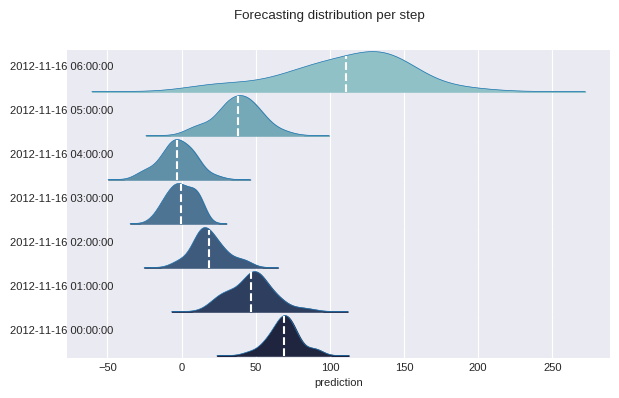

In [29]:
# Ridge plot of bootstrapping predictions
# ==============================================================================
_ = plot_prediction_distribution(boot_predictions, figsize=(7, 4))

These predictions can also be generated using `backtesting_forecaster` with the `interval` argument set to `bootstrapping`.

In [30]:
# Bootstrapping backtesting predictions
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24, 
         initial_train_size = len(data.loc[:end_validation]),
         refit              = False
     )

metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['users'],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = 'bootstrapping',  # Bootstrapping predictions
                          n_boot                  = 150,
                          use_in_sample_residuals = True,  # Use in-sample residuals
                          use_binned_residuals    = False,  
                          n_jobs                  = 'auto',
                          verbose                 = False,
                          show_progress           = True
                     )

predictions.head(3)

  0%|          | 0/45 [00:00<?, ?it/s]

,pred,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,...,pred_boot_140,pred_boot_141,pred_boot_142,pred_boot_143,pred_boot_144,pred_boot_145,pred_boot_146,pred_boot_147,pred_boot_148,pred_boot_149
2012-11-16 00:00:00,70.009970,75.866922,74.958504,89.749352,66.449068,55.227496,80.869209,69.924453,55.588950,46.061720,...,61.925019,62.899436,65.664475,101.212197,68.180614,81.179700,92.033364,72.539155,45.156079,69.724208
2012-11-16 01:00:00,45.679914,57.567154,58.751725,83.516090,48.878398,33.776836,84.586713,44.655496,50.736572,38.950681,...,47.550743,55.596103,43.062156,61.237442,59.615270,52.196407,27.639284,30.641615,28.361563,61.251224
2012-11-16 02:00:00,19.225220,5.228589,48.683457,31.879760,18.126599,44.136018,37.254636,11.040158,15.728778,46.707297,...,13.214447,21.918936,9.462689,16.782340,19.291102,14.049218,-14.634474,-6.843672,23.892199,46.247148


**Predict Interval**

In most cases, the user is interested in a specific interval rather than the entire bootstrapping simulation matrix. To address this need, skforecast provides the `predict_interval` method. This method internally uses `predict_bootstrapping` to obtain the bootstrapping matrix and estimates the upper and lower quantiles for each step, thus providing the user with the desired prediction intervals.

In [31]:
# Predict intervals for next 7 steps, quantiles 10th and 90th
# ==============================================================================
predictions = forecaster.predict_interval(
                  exog     = data_test[exog_features],
                  steps    = 7,
                  interval = [10, 90],
                  method   = 'bootstrapping',
                  n_boot   = 150
              )
predictions

,pred,lower_bound,upper_bound
2012-11-16 00:00:00,70.009970,55.588950,82.508596
2012-11-16 01:00:00,45.679914,28.470177,62.353076
2012-11-16 02:00:00,19.225220,4.018523,41.516050
2012-11-16 03:00:00,-0.039409,-13.844663,15.939604
2012-11-16 04:00:00,0.154831,-16.641050,13.854558
2012-11-16 05:00:00,37.330998,23.883717,54.783630
2012-11-16 06:00:00,116.737843,68.144911,142.313852


These predictions can also be generated using `backtesting_forecaster` with the `interval` argument as a list of two percentiles.

In [32]:
# Interval backtesting predictions
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['users'],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = [10, 90],  # Interval predictions
                          interval_method         = 'bootstrapping',
                          n_boot                  = 150,
                          use_in_sample_residuals = True,  # Use in-sample residuals
                          use_binned_residuals    = False,  
                          n_jobs                  = 'auto',
                          verbose                 = False,
                          show_progress           = True
                     )

predictions.head(3)

  0%|          | 0/45 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2012-11-16 00:00:00,70.009970,55.588950,82.508596
2012-11-16 01:00:00,45.679914,28.470177,62.353076
2012-11-16 02:00:00,19.225220,4.018523,41.516050


**Predict Quantile**

This method operates identically to `predict_interval`, with the added feature of enabling users to define a specific list of quantiles for estimation at each step. It's important to remember that these quantiles should be specified within the range of 0 to 1.

In [33]:
# Predict quantiles for next 7 steps, quantiles 5th, 25th, 75th and 95th
# ==============================================================================
predictions = forecaster.predict_quantiles(
                  exog      = data_test[exog_features],
                  steps     = 7,
                  n_boot    = 150,
                  quantiles = [0.05, 0.25, 0.75, 0.95],
              )
predictions

,q_0.05,q_0.25,q_0.75,q_0.95
2012-11-16 00:00:00,47.895605,62.904844,76.060832,85.852881
2012-11-16 01:00:00,23.458563,40.242031,56.417963,67.496957
2012-11-16 02:00:00,-4.535701,13.153782,30.118516,46.500230
2012-11-16 03:00:00,-17.612331,-5.324024,7.981939,22.511882
2012-11-16 04:00:00,-29.478956,-8.188890,5.211215,16.233749
2012-11-16 05:00:00,22.021738,32.193039,45.437903,58.342040
2012-11-16 06:00:00,59.707261,86.020965,129.639798,146.735405


These predictions can also be generated using `backtesting_forecaster` with the `interval` argument as a list of different percentiles.

In [34]:
# Percentile backtesting predictions
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['users'],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = [5, 25, 75, 95],  # Different percentiles
                          interval_method         = 'bootstrapping',
                          n_boot                  = 150,
                          use_in_sample_residuals = True,  # Use in-sample residuals
                          use_binned_residuals    = False,  
                          n_jobs                  = 'auto',
                          verbose                 = False,
                          show_progress           = True
                     )

predictions.head(3)

  0%|          | 0/45 [00:00<?, ?it/s]

,pred,p_5,p_25,p_75,p_95
2012-11-16 00:00:00,70.009970,47.895605,62.904844,76.060832,85.852881
2012-11-16 01:00:00,45.679914,23.458563,40.242031,56.417963,67.496957
2012-11-16 02:00:00,19.225220,-4.535701,13.153782,30.118516,46.500230


**Predict Distribution**

The intervals estimated so far are distribution-free, which means that no assumptions are made about a particular distribution. The `predict_dist` method in skforecast allows fitting a parametric distribution to the bootstrapped prediction samples obtained with `predict_bootstrapping`. This is useful when there is reason to believe that the forecast errors follow a particular distribution, such as the normal distribution or the student's t-distribution. The `predict_dist` method allows the user to specify any continuous distribution from the [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions) module.

In [35]:
# Predict the parameters of a normal distribution for the next 7 steps
# ==============================================================================
predictions = forecaster.predict_dist(
                  exog         = data_test[exog_features],
                  steps        = 7,
                  n_boot       = 150,
                  distribution = norm
              )
predictions

,loc,scale
2012-11-16 00:00:00,69.246122,11.443606
2012-11-16 01:00:00,47.149645,13.731953
2012-11-16 02:00:00,21.183596,14.787970
2012-11-16 03:00:00,1.137208,11.642410
2012-11-16 04:00:00,-2.525007,12.890002
2012-11-16 05:00:00,38.478812,12.083966
2012-11-16 06:00:00,106.244365,27.686430


These predictions can also be generated using `backtesting_forecaster` with the `interval` argument as a scipy.stats distribution.

In [36]:
# Percentile backtesting predictions
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['users'],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = norm,  # Scipy distribution
                          interval_method         = 'bootstrapping',
                          n_boot                  = 150,
                          use_in_sample_residuals = True,  # Use in-sample residuals
                          use_binned_residuals    = False,  
                          n_jobs                  = 'auto',
                          verbose                 = False,
                          show_progress           = True
                     )

predictions.head(3)

  0%|          | 0/45 [00:00<?, ?it/s]

,pred,loc,scale
2012-11-16 00:00:00,70.009970,69.246122,11.443606
2012-11-16 01:00:00,45.679914,47.149645,13.731953
2012-11-16 02:00:00,19.225220,21.183596,14.787970


## Conformal prediction

## Prediction intervals using quantile regression models


As opposed to linear regression, which is intended to estimate the conditional mean of the response variable given certain values of the predictor variables, quantile regression aims at estimating the conditional quantiles of the response variable. For a continuous distribution function, the $\alpha$-quantile $Q_{\alpha}(x)$ is defined such that the probability of $Y$ being smaller than $Q_{\alpha}(x)$ is, for a given $X=x$, equal to $\alpha$. For example, 36% of the population values are lower than the quantile  $Q=0.36$. The most known quantile is the 50%-quantile, more commonly called the median.

By combining the predictions of two quantile regressors, it is possible to build an interval. Each model estimates one of the limits of the interval. For example, the models obtained for $Q = 0.1$ and $Q = 0.9$ produce an 80% prediction interval (90% - 10% = 80%).

Several machine learning algorithms are capable of modeling quantiles. Some of them are:

+ [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html)

+ [XGBoost](https://xgboost.readthedocs.io/en/stable/python/index.html)

+ [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor)

+ [Scikit-learn HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html)

+ [Scikit-learn QuantileRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.QuantileRegressor.html#sklearn.linear_model.QuantileRegressor)

+ [skranger quantile RandomForest](https://skranger.readthedocs.io/en/stable/index.html)


Just as the squared-error loss function is used to train models that predict the mean value, a specific loss function is needed in order to train models that predict quantiles. The most common metric used for quantile regression is calles [quantile loss  or pinball loss](https://en.wikipedia.org/wiki/Quantile_regression):


$$\text{pinball}(y, \hat{y}) = \frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}}-1}  \alpha \max(y_i - \hat{y}_i, 0) + (1 - \alpha) \max(\hat{y}_i - y_i, 0)$$

where $\alpha$ is the target quantile, $y$ the real value and $\hat{y}$ the quantile prediction.

It can be seen that loss differs depending on the evaluated quantile. The higher the quantile, the more the loss function penalizes underestimates, and the less it penalizes overestimates. As with MSE and MAE, the goal is to minimize its values (the lower loss, the better).

Two disadvantages of quantile regression, compared to the bootstrap approach to prediction intervals, are that each quantile needs its regressor and quantile regression is not available for all types of regression models. However, once the models are trained, the inference is much faster since no iterative process is needed.

This type of prediction intervals can be easily estimated using [ForecasterDirect](../api/forecasterdirect.html) and [ForecasterDirectMultiVariate](../api/forecasterdirectmultivariate.html) models.

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

Forecasters of type <code>ForecasterDirect</code> are slower than <code>ForecasterRecursive</code> because they require training one model per step. Although they can achieve better performance, their scalability is an important limitation when many steps need to be predicted. To limit the time required to run the following examples, the data is aggregated from hourly frequency to daily frequency and only 7 steps ahead (one week) are predicted.

</div>

In [37]:
# Data download
# ==============================================================================
data = fetch_dataset(name='vic_electricity')

vic_electricity
---------------
Half-hourly electricity demand for Victoria, Australia
O'Hara-Wild M, Hyndman R, Wang E, Godahewa R (2022).tsibbledata: Diverse
Datasets for 'tsibble'. https://tsibbledata.tidyverts.org/,
https://github.com/tidyverts/tsibbledata/.
https://tsibbledata.tidyverts.org/reference/vic_elec.html
Shape of the dataset: (52608, 4)


In [38]:
# Data preparation (aggregation at daily level)
# ==============================================================================
data = data.resample(rule="D", closed="left", label="right").agg(
    {"Demand": "sum", "Temperature": "mean", "Holiday": "max"}
)
data.head(3)

,Demand,Temperature,Holiday
Time,,,
2012-01-01,82531.745918,21.047727,True
2012-01-02,227778.257304,26.578125,True
2012-01-03,275490.988882,31.751042,True


In [39]:
# Split data into train-validation-test
# ==============================================================================
data = data.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
end_train = '2013-12-31 23:59:00'
end_validation = '2014-9-30 23:59:00'
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(
    f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}"
    f"  (n={len(data_train)})"
)
print(
    f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}"
    f"  (n={len(data_val)})"
)
print(
    f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}"
    f"  (n={len(data_test)})"
)

Train dates      : 2012-01-01 00:00:00 --- 2013-12-31 00:00:00  (n=731)
Validation dates : 2014-01-01 00:00:00 --- 2014-09-30 00:00:00  (n=273)
Test dates       : 2014-10-01 00:00:00 --- 2014-12-30 00:00:00  (n=91)


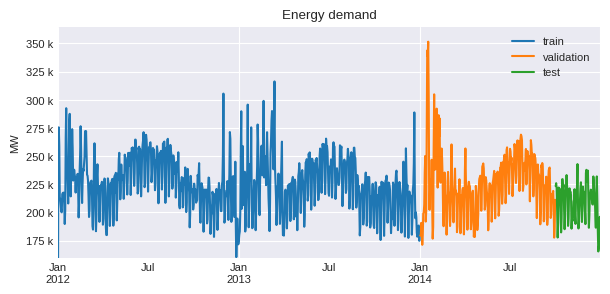

In [40]:
# Plot time series partition
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Demand'].plot(label='train', ax=ax)
data_val['Demand'].plot(label='validation', ax=ax)
data_test['Demand'].plot(label='test', ax=ax)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylim(bottom=160_000)
ax.set_ylabel('MW')
ax.set_xlabel('')
ax.set_title('Energy demand')
ax.legend();

### Quantile regresion models

An 80% prediction interval is estimated for 7 steps-ahead predictions using quantile regression. A LightGBM gradient boosting model is trained in this example, however, the reader may use any other model just replacing the definition of the regressor.

In [41]:
# Create forecasters: one for each bound of the interval
# ==============================================================================
# The forecasters obtained for alpha=0.1 and alpha=0.9 produce a 80% confidence
# interval (90% - 10% = 80%).

# Forecaster for quantile 10%
forecaster_q10 = ForecasterDirect(
                     regressor = LGBMRegressor(
                                     objective     = 'quantile',
                                     metric        = 'quantile',
                                     alpha         = 0.1,
                                     learning_rate = 0.01,
                                     max_depth     = 3,
                                     n_estimators  = 500,
                                     verbose       = -1
                                 ),
                     lags = 7,
                     steps = 7
                 )
                  
# Forecaster for quantile 90%
forecaster_q90 = ForecasterDirect(
                     regressor = LGBMRegressor(
                                     objective     = 'quantile',
                                     metric        = 'quantile',
                                     alpha         = 0.9,
                                     learning_rate = 0.1,
                                     max_depth     = 3,
                                     n_estimators  = 100,
                                     verbose       = -1
                                 ),
                     lags = 7,
                     steps = 7
                 )

forecaster_q10.fit(y=data['Demand'])
forecaster_q90.fit(y=data['Demand'])

When validating a quantile regression model, a custom metric must be provided depending on the quantile being estimated.

In [42]:
# Loss function for each quantile (pinball_loss)
# ==============================================================================
def mean_pinball_loss_q10(y_true, y_pred):
    """
    Pinball loss for quantile 10.
    """
    return mean_pinball_loss(y_true, y_pred, alpha=0.1)


def mean_pinball_loss_q90(y_true, y_pred):
    """
    Pinball loss for quantile 90.
    """
    return mean_pinball_loss(y_true, y_pred, alpha=0.9)

### Predictions (backtesting)

Once the quantile forecasters are trained, they can be used to predict each of the bounds of the forecasting interval.

In [43]:
# Backtesting on test data
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 7, 
         initial_train_size = len(data.loc[:end_validation]),
         refit              = False
     )

metric_q10, predictions_q10 = backtesting_forecaster(
                                  forecaster    = forecaster_q10,
                                  y             = data['Demand'],
                                  cv            = cv,
                                  metric        = mean_pinball_loss_q10,
                                  n_jobs        = 'auto',
                                  verbose       = False,
                                  show_progress = True
                              )

metric_q90, predictions_q90 = backtesting_forecaster(
                                  forecaster    = forecaster_q90,
                                  y             = data['Demand'],
                                  cv            = cv,
                                  metric        = mean_pinball_loss_q90,
                                  n_jobs        = 'auto',
                                  verbose       = False,
                                  show_progress = True
                              )

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

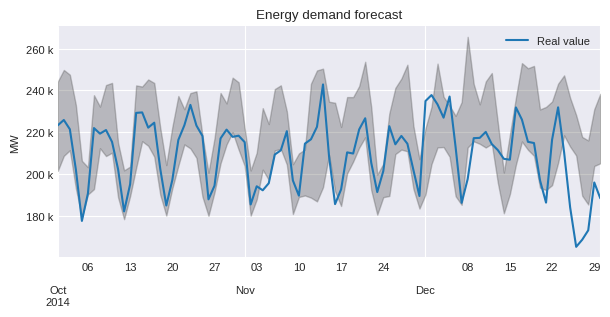

In [44]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[end_validation:, 'Demand'].plot(ax=ax, label='Real value')
ax.fill_between(
    data.loc[end_validation:].index,
    predictions_q10['pred'],
    predictions_q90['pred'],
    color = '#444444',
        alpha = 0.3,
)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylabel('MW')
ax.set_xlabel('')
ax.set_title('Energy demand forecast')
ax.legend();

Predictions generated for each model are used to define the upper and lower limits of the interval.

In [46]:
# Predicted interval coverage (on test data)
# ==============================================================================
coverage = calculate_coverage(
    y_true      = data.loc[end_validation:, 'Demand'],
    lower_bound = predictions_q10["pred"], 
    upper_bound = predictions_q90["pred"]
)
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions_q90["pred"] - predictions_q10["pred"]).sum()
print(f"Area of the interval: {round(area, 2)}")

Predicted interval coverage: 74.73 %
Area of the interval: 2832564.24
